<a href="https://colab.research.google.com/github/JyothyVariyampat/Benchmark-ML-and-DL-Models-for-Small-Molecule-Immunity-Target-Bioactivity-Prediction./blob/main/CW_AID_1259354.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#AID932_data_for_classification_08Nov202.csv

# PyTorch version: 2.6.0+cu124
# NumPy version: 1.24.4
# Pandas version: 2.2.2
# RDKit version: 2022.09.5

# selected concepts: # 1. Topological Polar Surface Area, LogP, Hydrogen Bond Donors, Number of Aromatic Rings, Molar Refractivity

In [ ]:
# Environment setup
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Debug CUDA asserts
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu118.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu118.html
# !pip install torch-geometric

#!pip install torch_geometric
!pip install torch-geometric==2.5.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00


In [ ]:
!pip install rdkit-pypi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 74.2 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.24.4
import os
os.kill(os.getpid(), 9)  # Restart the Colab runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 102.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, SanitizeMol
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ModelMode, ModelReturnType

In [ ]:
# from torch_geometric.explain import Explainer, GNNExplainer
# from torch_geometric.explain.config import ModelConfig, ModelMode, ModelReturnType


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Data loading and preprocessing
# def compute_rdkit_features(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None
#     try:
#         # Attempt to sanitize the molecule
#         SanitizeMol(mol)
#     except:
#         print(f"Failed to sanitize SMILES: {smiles}")
#         return None
#     return [
#         Descriptors.MolWt(mol),
#         Descriptors.MolLogP(mol),
#         Descriptors.TPSA(mol),
#         Descriptors.NumHDonors(mol),
#         Descriptors.NumHAcceptors(mol)
#     ]

from rdkit.Chem import Lipinski

def compute_rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        SanitizeMol(mol)
    except:
        print(f"Failed to sanitize SMILES: {smiles}")
        return None

    # Compute updated concept descriptors
    return [
        Descriptors.TPSA(mol),                  # 1. Topological Polar Surface Area
        Descriptors.MolLogP(mol),               # 2. LogP
        Descriptors.NumHDonors(mol),            # 3. Hydrogen Bond Donors
        #Lipinski.NumAromaticRings(mol),         # 4. Number of Aromatic Rings
        Descriptors.NumRotatableBonds(mol),     # 4. NumRotatableBonds
        Descriptors.MolMR(mol)                  # 5. Molar Refractivity
    ]



# def mol_to_graph(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None
#     G = nx.Graph()
#     for atom in mol.GetAtoms():
#         G.add_node(atom.GetIdx(), x=torch.tensor([atom.GetAtomicNum()], dtype=torch.float))
#     for bond in mol.GetBonds():
#         start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
#         G.add_edge(start, end)
#     data = from_networkx(G)
#     data.x = torch.stack([feat["x"] for _, feat in G.nodes(data=True)])
#     return data

def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), x=torch.tensor([atom.GetAtomicNum()], dtype=torch.float))
    edge_indices = []
    edge_attrs = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        G.add_edge(start, end)
        edge_indices.append((start, end))
        edge_indices.append((end, start))  # For undirected graph
        bond_type = bond.GetBondTypeAsDouble()  # Simplified edge feature
        edge_attrs.append([bond_type])
        edge_attrs.append([bond_type])
    data = from_networkx(G)
    data.x = torch.stack([feat["x"] for _, feat in G.nodes(data=True)])
    data.edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    data.edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    return data


def load_dataset(csv_path):
    df = pd.read_csv(csv_path)
    dataset, failed = [], 0
    for idx, row in df.iterrows():
        smiles = row['SMILES']
        label = 1 if row['PUBCHEM_ACTIVITY_OUTCOME'].lower() == 'active' else 0
        features = compute_rdkit_features(smiles)
        graph = mol_to_graph(smiles)
        if features is None or graph is None:
            failed += 1
            continue
        graph.y = torch.tensor(label, dtype=torch.long)
        graph.mol_features = torch.tensor(features, dtype=torch.float)
        dataset.append(graph)
    print(f"Processed {len(dataset)} molecules. Failed: {failed}")
    return dataset, df

In [ ]:
# CHANGE THIS PATH to your CSV file
csv_path = "/content/drive/MyDrive/Datasets/AID_1259354/AID1259354Active_Inactive_Molecules_CW.csv"
dataset, df_raw = load_dataset(csv_path)

Processed 3649 molecules. Failed: 0


In [ ]:
# Data splitting
train_idx, test_idx = train_test_split(
    range(len(dataset)), test_size=0.2,
    stratify=[data.y.item() for data in dataset], random_state=42)

train_set = [dataset[i] for i in train_idx]
test_set = [dataset[i] for i in test_idx]

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)


In [ ]:
# Model definition
from torch_geometric.nn import AttentiveFP

# Define Concept Whitening Layer
class ConceptWhiteningLayer(nn.Module):
    def __init__(self, input_dim, concept_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, concept_dim)
        self.R = nn.Parameter(torch.eye(concept_dim), requires_grad=True)

    def forward(self, x, concept_vectors):
        x_centered = x - x.mean(dim=0, keepdim=True)
        concept_space = self.proj(x_centered)
        aligned = concept_space @ self.R
        self.loss = F.mse_loss(aligned, concept_vectors) if concept_vectors is not None else torch.tensor(0.0, device=x.device)
        return aligned

class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x

class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_dim, concept_dim, num_classes):
        super().__init__()
        self.encoder = GCNEncoder(in_channels, hidden_dim)
        self.pool = global_mean_pool
        self.cw_layer = ConceptWhiteningLayer(hidden_dim, concept_dim)
        self.fc = nn.Linear(concept_dim, num_classes)

    def forward(self, data):
        x = self.encoder(data.x, data.edge_index)
        x = self.pool(x, data.batch)
        mol_concepts = data.mol_features.view(x.size(0), -1)
        x = self.cw_layer(x, mol_concepts)
        return self.fc(x), self.cw_layer.loss

In [ ]:
# Training functions
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, align_loss = model(data)
        cls_loss = F.cross_entropy(out, data.y)
        loss = cls_loss + align_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    for data in loader:
        data = data.to(device)
        out, _ = model(data)
        prob = F.softmax(out, dim=1)[:, 1]
        pred = out.argmax(dim=1)
        y_true += data.y.cpu().tolist()
        y_pred += pred.cpu().tolist()
        y_prob += prob.cpu().tolist()
    return accuracy_score(y_true, y_pred), roc_auc_score(y_true, y_prob)


In [ ]:
# Model, optimizer initialization
in_channels = dataset[0].x.shape[1]
model = GCNClassifier(in_channels, 128, 5, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# Training loop
for epoch in range(1, 31):
    loss = train(model, train_loader, optimizer)
    acc, roc = evaluate(model, test_loader)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Accuracy: {acc:.4f} | ROC-AUC: {roc:.4f}")


Epoch 01 | Loss: 3020.2567 | Accuracy: 0.5000 | ROC-AUC: 0.5028
Epoch 02 | Loss: 3017.7763 | Accuracy: 0.5000 | ROC-AUC: 0.5028
Epoch 03 | Loss: 3018.5940 | Accuracy: 0.5000 | ROC-AUC: 0.5028
Epoch 04 | Loss: 3020.0956 | Accuracy: 0.5000 | ROC-AUC: 0.5028
Epoch 05 | Loss: 3017.9108 | Accuracy: 0.5000 | ROC-AUC: 0.5028
Epoch 06 | Loss: 3016.0072 | Accuracy: 0.5000 | ROC-AUC: 0.5028
Epoch 07 | Loss: 3017.3647 | Accuracy: 0.5000 | ROC-AUC: 0.5028
Epoch 08 | Loss: 3015.2413 | Accuracy: 0.5164 | ROC-AUC: 0.5028
Epoch 09 | Loss: 3017.0081 | Accuracy: 0.5137 | ROC-AUC: 0.5028
Epoch 10 | Loss: 3014.2364 | Accuracy: 0.5164 | ROC-AUC: 0.5028
Epoch 11 | Loss: 3014.7649 | Accuracy: 0.5123 | ROC-AUC: 0.5028
Epoch 12 | Loss: 3013.4842 | Accuracy: 0.5068 | ROC-AUC: 0.5028
Epoch 13 | Loss: 3011.0811 | Accuracy: 0.5082 | ROC-AUC: 0.5028
Epoch 14 | Loss: 3012.3813 | Accuracy: 0.5068 | ROC-AUC: 0.5028
Epoch 15 | Loss: 3010.1067 | Accuracy: 0.5041 | ROC-AUC: 0.5028
Epoch 16 | Loss: 3009.6933 | Accuracy: 0


 Running Explainability on Last 5 Molecules...

🔬 Molecule 726
SMILES: C1=CC(=CC(=C1)F)NC(=O)CC(=O)NC2=CC(=CC=C2)F
TPSA: 58.200
LogP: 2.932
NumHDonors: 2.000
NumRotatableBonds: 4.000
MolMR: 74.676
Node mask has constant values. Skipping visualization.


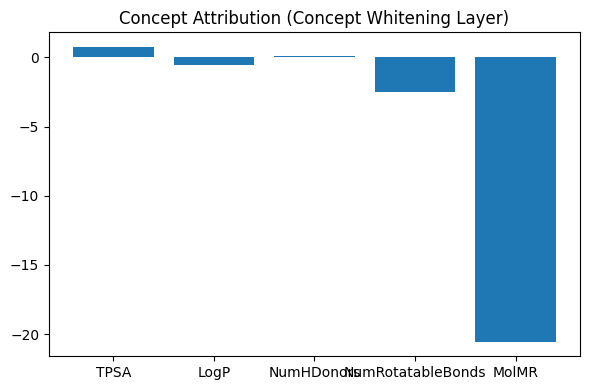


🔬 Molecule 727
SMILES: CCC1=CC(=C(C=C1O)O)C(=O)CN2C=NC3=CC=CC=C32
TPSA: 75.350
LogP: 2.893
NumHDonors: 2.000
NumRotatableBonds: 4.000
MolMR: 83.213
Node mask has constant values. Skipping visualization.


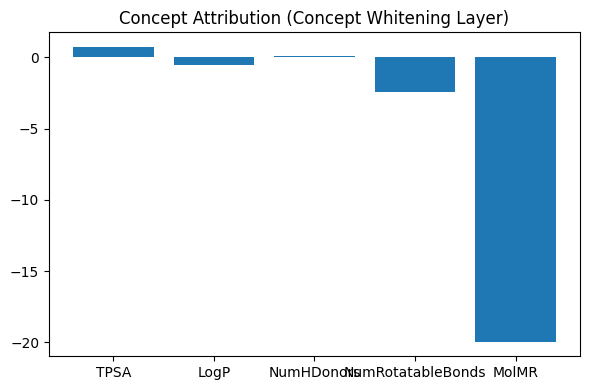


🔬 Molecule 728
SMILES: CCOC1=CC=C(C=C1)S(=O)(=O)N=C2C=C(C(=O)C3=CC=CC=C32)NC4=CC=C(C=C4)OC
TPSA: 94.060
LogP: 4.464
NumHDonors: 1.000
NumRotatableBonds: 7.000
MolMR: 126.806
Node mask has constant values. Skipping visualization.


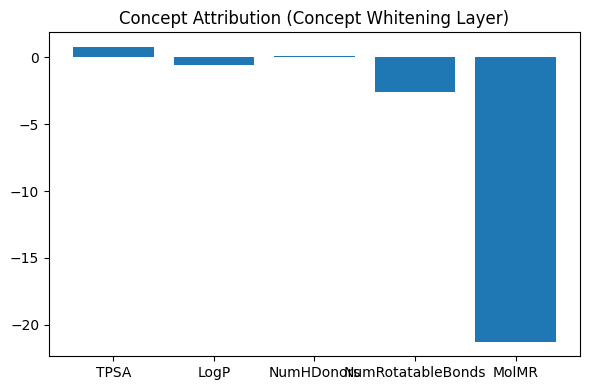


🔬 Molecule 729
SMILES: COC1=CC=CC(=C1)CC(=O)NCC2=C3C=CC=CN3N=C2
TPSA: 55.630
LogP: 2.202
NumHDonors: 1.000
NumRotatableBonds: 5.000
MolMR: 83.737
Node mask has constant values. Skipping visualization.


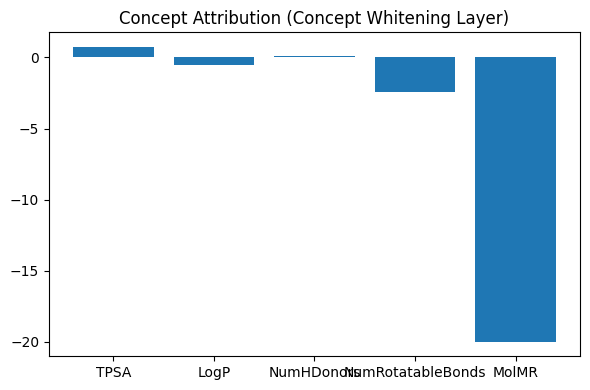


🔬 Molecule 730
SMILES: CC1=CC(=NC(=O)N1CCNC(=O)C2=NC=CN2)C
TPSA: 92.670
LogP: 0.013
NumHDonors: 2.000
NumRotatableBonds: 4.000
MolMR: 68.892
Node mask has constant values. Skipping visualization.


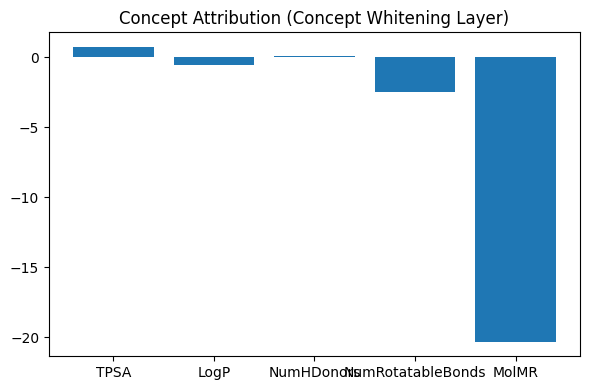

In [ ]:
# Explanation utilities
class WrappedModel(nn.Module):
    def __init__(self, base_model, mol_features):
        super().__init__()
        self.base_model = base_model
        self.mol_features = mol_features

    def forward(self, x, edge_index, batch, **kwargs):
        data = Data(x=x, edge_index=edge_index, batch=batch)
        data.mol_features = self.mol_features
        out, _ = self.base_model(data)
        return out

def visualize_rdkit_colored(smiles, node_mask):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Invalid SMILES:", smiles)
        return

    try:
        node_mask = node_mask.cpu().detach().numpy()

        # Handle NaN or Inf values
        if np.isnan(node_mask).any() or np.isinf(node_mask).any():
            print("Node mask contains NaN or Inf values. Skipping visualization.")
            return

        # Avoid division by zero
        if np.allclose(node_mask.max(), node_mask.min()):
            print("Node mask has constant values. Skipping visualization.")
            return

        # Normalize node mask
        node_mask = (node_mask - node_mask.min()) / (node_mask.max() - node_mask.min() + 1e-8)
        atom_weights = {i: float(node_mask[i]) for i in range(len(node_mask))}

        # Generate the image
        img = Draw.MolToImage(
            mol,
            size=(400, 300),
            highlightAtoms=list(atom_weights.keys()),
            highlightAtomColors={i: (1.0, 0.5 * w, 0.5 * w) for i, w in atom_weights.items()},
        )

        plt.figure(figsize=(4, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.title("RDKit Atom Attribution Map")
        plt.show()

    except Exception as e:
        print("RDKit Visualization Error:", e)

def plot_concept_importance(model, data, device, concept_names=None):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = model.encoder(x, edge_index)
        x = model.pool(x, batch)
        concepts = model.cw_layer.proj(x) @ model.cw_layer.R
        concepts = concepts[0].cpu().numpy()

    if concept_names is None:
        concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]




    plt.figure(figsize=(6, 4))
    plt.bar(concept_names, concepts)
    plt.title("Concept Attribution (Concept Whitening Layer)")
    plt.tight_layout()
    plt.show()

# Explanation loop
# print("\nRunning Explainability on Last 5 Molecules...")
# last_five_indices = list(range(len(test_set) - 5, len(test_set)))

# for i in last_five_indices:
#     print(f"\n Molecule {i+1}")
#     sample = test_set[i].to(device)

#     # Skip small molecules
#     if len(sample.x) < 3:
#         print("Skipping molecule with too few atoms")
#         continue

#     try:
#         wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)  # Ensure model is on the same device
#         explainer = Explainer(
#             model=wrapped_model,
#             algorithm=GNNExplainer(epochs=200),
#             explanation_type='model',
#             node_mask_type='attributes',
#             edge_mask_type='object',
#             model_config=ModelConfig(
#                 mode=ModelMode.binary_classification,
#                 task_level='graph',
#                 return_type=ModelReturnType.probs,
#             )
#         )

#         explanation = explainer(
#             x=sample.x,
#             edge_index=sample.edge_index,
#             batch=sample.batch
#         )

#         node_mask = explanation.node_mask
#         smiles = df_raw.iloc[train_idx[i]]['SMILES']  # Correct SMILES extraction
#         visualize_rdkit_colored(smiles, node_mask)
#         plot_concept_importance(model, sample, device)

#     except Exception as e:
#         print(f" Failed to explain molecule {i}: {e}")

# 🔍 Explanation loop for last 5 test molecules
print("\n Running Explainability on Last 5 Molecules...")
last_five_indices = list(range(len(test_set) - 5, len(test_set)))

concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]

for j, i in enumerate(last_five_indices):
    print(f"\n🔬 Molecule {len(test_set) - 5 + j + 1}")
    sample = test_set[i].to(device)

    # Skip small molecules
    if len(sample.x) < 3:
        print("Skipping molecule with too few atoms")
        continue

    try:
        # Print SMILES + Concept values
        smiles = df_raw.iloc[test_idx[i]]['SMILES']  # Correct indexing
        concept_values = sample.mol_features.cpu().numpy()

        print(f"SMILES: {smiles}")
        for name, value in zip(concept_names, concept_values):
            print(f"{name}: {value:.3f}")

        # Wrap the model
        wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)

        # GNNExplainer setup
        explainer = Explainer(
            model=wrapped_model,
            algorithm=GNNExplainer(epochs=200),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=ModelConfig(
                mode=ModelMode.binary_classification,
                task_level='graph',
                return_type=ModelReturnType.probs,
            )
        )

        # Generate explanation
        explanation = explainer(
            x=sample.x,
            edge_index=sample.edge_index,
            batch=sample.batch
        )

        node_mask = explanation.node_mask

        # 🔬 RDKit visualization
        visualize_rdkit_colored(smiles, node_mask)

        # 📊 Concept attribution bar plot
        plot_concept_importance(model, sample, device, concept_names)

    except Exception as e:
        print(f"Failed to explain molecule {i}: {e}")



 Running Explainability on Last 5 Molecules...

🔬 Molecule 726
SMILES: C1=CC(=CC(=C1)F)NC(=O)CC(=O)NC2=CC(=CC=C2)F
TPSA: 58.200
LogP: 2.932
NumHDonors: 2.000
NumAromaticRings: 4.000
MolMR: 74.676
Node mask has constant values. Skipping visualization.


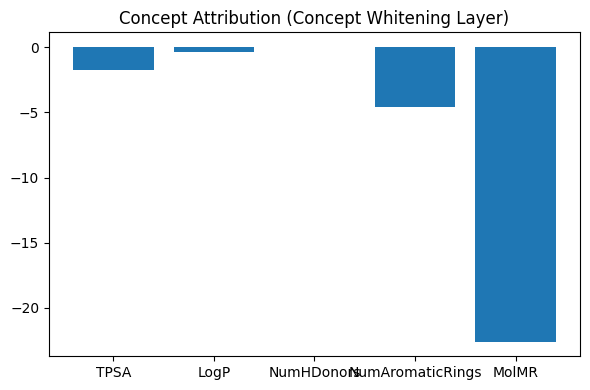


🔬 Molecule 727
SMILES: CCC1=CC(=C(C=C1O)O)C(=O)CN2C=NC3=CC=CC=C32
TPSA: 75.350
LogP: 2.893
NumHDonors: 2.000
NumAromaticRings: 4.000
MolMR: 83.213
Node mask has constant values. Skipping visualization.


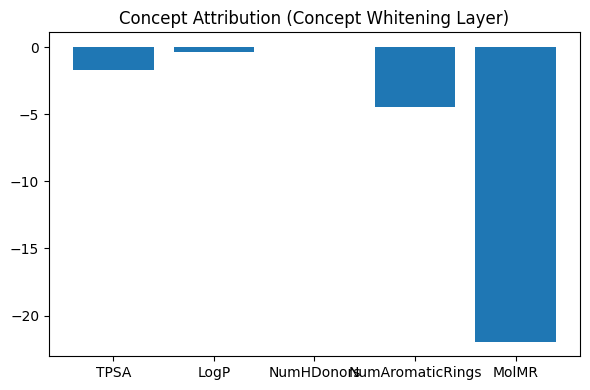


🔬 Molecule 728
SMILES: CCOC1=CC=C(C=C1)S(=O)(=O)N=C2C=C(C(=O)C3=CC=CC=C32)NC4=CC=C(C=C4)OC
TPSA: 94.060
LogP: 4.464
NumHDonors: 1.000
NumAromaticRings: 7.000
MolMR: 126.806
Node mask has constant values. Skipping visualization.


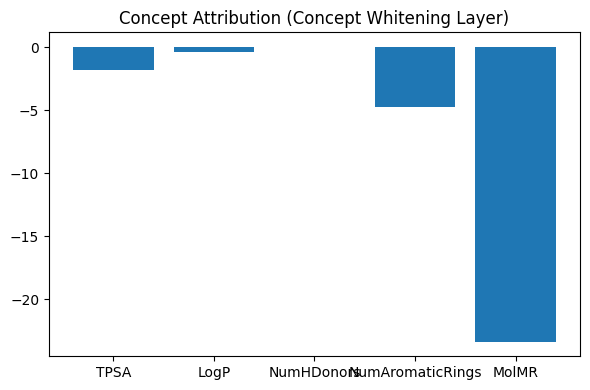


🔬 Molecule 729
SMILES: COC1=CC=CC(=C1)CC(=O)NCC2=C3C=CC=CN3N=C2
TPSA: 55.630
LogP: 2.202
NumHDonors: 1.000
NumAromaticRings: 5.000
MolMR: 83.737
Node mask has constant values. Skipping visualization.


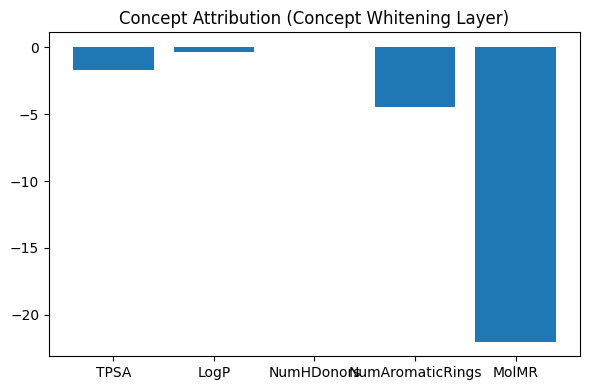


🔬 Molecule 730
SMILES: CC1=CC(=NC(=O)N1CCNC(=O)C2=NC=CN2)C
TPSA: 92.670
LogP: 0.013
NumHDonors: 2.000
NumAromaticRings: 4.000
MolMR: 68.892
Node mask has constant values. Skipping visualization.


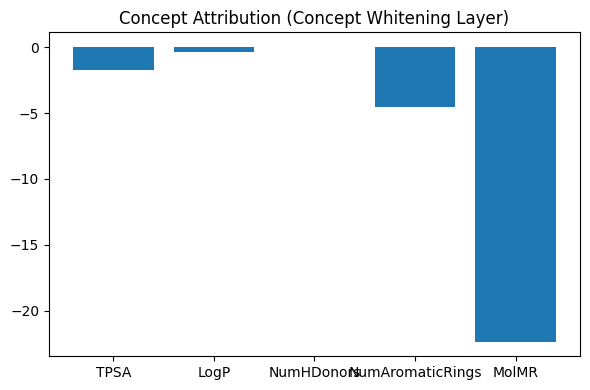

In [ ]:
# Explanation utilities
class WrappedModel(nn.Module):
    def __init__(self, base_model, mol_features):
        super().__init__()
        self.base_model = base_model
        self.mol_features = mol_features

    def forward(self, x, edge_index, batch, **kwargs):
        data = Data(x=x, edge_index=edge_index, batch=batch)
        data.mol_features = self.mol_features
        out, _ = self.base_model(data)
        return out

def visualize_rdkit_colored(smiles, node_mask):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Invalid SMILES:", smiles)
        return

    try:
        node_mask = node_mask.cpu().detach().numpy()

        # Handle NaN or Inf values
        if np.isnan(node_mask).any() or np.isinf(node_mask).any():
            print("Node mask contains NaN or Inf values. Skipping visualization.")
            return

        # Avoid division by zero
        if np.allclose(node_mask.max(), node_mask.min()):
            print("Node mask has constant values. Skipping visualization.")
            return

        # Normalize node mask
        node_mask = (node_mask - node_mask.min()) / (node_mask.max() - node_mask.min() + 1e-8)
        atom_weights = {i: float(node_mask[i]) for i in range(len(node_mask))}

        # Generate the image
        img = Draw.MolToImage(
            mol,
            size=(400, 300),
            highlightAtoms=list(atom_weights.keys()),
            highlightAtomColors={i: (1.0, 0.5 * w, 0.5 * w) for i, w in atom_weights.items()},
        )

        plt.figure(figsize=(4, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.title("RDKit Atom Attribution Map")
        plt.show()

    except Exception as e:
        print("RDKit Visualization Error:", e)

def plot_concept_importance(model, data, device, concept_names=None):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = model.encoder(x, edge_index)
        x = model.pool(x, batch)
        concepts = model.cw_layer.proj(x) @ model.cw_layer.R
        concepts = concepts[0].cpu().numpy()

    if concept_names is None:
        concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]




    plt.figure(figsize=(6, 4))
    plt.bar(concept_names, concepts)
    plt.title("Concept Attribution (Concept Whitening Layer)")
    plt.tight_layout()
    plt.show()

# Explanation loop
# print("\nRunning Explainability on Last 5 Molecules...")
# last_five_indices = list(range(len(test_set) - 5, len(test_set)))

# for i in last_five_indices:
#     print(f"\n Molecule {i+1}")
#     sample = test_set[i].to(device)

#     # Skip small molecules
#     if len(sample.x) < 3:
#         print("Skipping molecule with too few atoms")
#         continue

#     try:
#         wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)  # Ensure model is on the same device
#         explainer = Explainer(
#             model=wrapped_model,
#             algorithm=GNNExplainer(epochs=200),
#             explanation_type='model',
#             node_mask_type='attributes',
#             edge_mask_type='object',
#             model_config=ModelConfig(
#                 mode=ModelMode.binary_classification,
#                 task_level='graph',
#                 return_type=ModelReturnType.probs,
#             )
#         )

#         explanation = explainer(
#             x=sample.x,
#             edge_index=sample.edge_index,
#             batch=sample.batch
#         )

#         node_mask = explanation.node_mask
#         smiles = df_raw.iloc[train_idx[i]]['SMILES']  # Correct SMILES extraction
#         visualize_rdkit_colored(smiles, node_mask)
#         plot_concept_importance(model, sample, device)

#     except Exception as e:
#         print(f" Failed to explain molecule {i}: {e}")

# 🔍 Explanation loop for last 5 test molecules
print("\n Running Explainability on Last 5 Molecules...")
last_five_indices = list(range(len(test_set) - 5, len(test_set)))

concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]

for j, i in enumerate(last_five_indices):
    print(f"\n🔬 Molecule {len(test_set) - 5 + j + 1}")
    sample = test_set[i].to(device)

    # Skip small molecules
    if len(sample.x) < 3:
        print("Skipping molecule with too few atoms")
        continue

    try:
        # Print SMILES + Concept values
        smiles = df_raw.iloc[test_idx[i]]['SMILES']  # Correct indexing
        concept_values = sample.mol_features.cpu().numpy()

        print(f"SMILES: {smiles}")
        for name, value in zip(concept_names, concept_values):
            print(f"{name}: {value:.3f}")

        # Wrap the model
        wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)

        # GNNExplainer setup
        explainer = Explainer(
            model=wrapped_model,
            algorithm=GNNExplainer(epochs=200),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=ModelConfig(
                mode=ModelMode.binary_classification,
                task_level='graph',
                return_type=ModelReturnType.probs,
            )
        )

        # Generate explanation
        explanation = explainer(
            x=sample.x,
            edge_index=sample.edge_index,
            batch=sample.batch
        )

        node_mask = explanation.node_mask

        # 🔬 RDKit visualization
        visualize_rdkit_colored(smiles, node_mask)

        # 📊 Concept attribution bar plot
        plot_concept_importance(model, sample, device, concept_names)

    except Exception as e:
        print(f"Failed to explain molecule {i}: {e}")


In [ ]:
# 🧪 Generate Concept Descriptor Table for Visualization
concept_table = []
for i, row in df_raw.iterrows():
    smi = row['SMILES']
    feats = compute_rdkit_features(smi)
    if feats:
        concept_table.append({
            "SMILES": smi,
            "TPSA": feats[0],
            "LogP": feats[1],
            "NumHDonors": feats[2],
            "NumAromaticRings": feats[3],
            "MolMR": feats[4],
        })

# 📊 Convert to DataFrame and display top rows
df_concepts = pd.DataFrame(concept_table)
print(f"✅ Generated concept table with {len(df_concepts)} molecules.")
df_concepts.head(10)  # Show first 10 entries


✅ Generated concept table with 3649 molecules.


,SMILES,TPSA,LogP,NumHDonors,NumAromaticRings,MolMR
0,C1=CC=C2C(=C1)C(=NS(=O)(=O)C3=CC=C(C=C3)F)C=C(...,112.90,3.89420,2,5,116.0023
1,CC\1=C(C(=O)NC(=O)/C1=C\C2=CC=C(O2)C3=CC(=CC=C...,126.24,2.73468,1,3,90.2381
2,CCN1/C(=C/2\C(=O)OC(=N2)C3=CC=CC=C3)/C=CC4=CC=...,41.90,3.75490,0,2,94.5930
3,C1CNCCC1NC2=NC3=C(C=CN3)C(=C2)C4=NC=CC=N4,78.52,2.18380,3,3,86.6341
4,CC1=CC=CC=C1OCC2=NC(=C(O2)NCCC3=CC=C(C=C3)OC)C#N,80.31,4.09690,1,8,101.9167
5,C1=CC=C(C=C1)COC2=NSC3=CC(=CC(=C32)[N+](=O)[O-...,108.40,3.69170,0,5,83.7028
6,C1=CC=C(C=C1)C2=C3C=C(C(=O)C=C3OC4=CC(=C(C=C42...,90.90,3.68160,3,1,89.5364
7,C1CCN(CC1)S(=O)(=O)C2=CC=CC(=C2)C(=O)NC3=CC=CC...,109.62,3.02170,1,5,100.1014
8,CCN(CC)CCCNC1=C2CCCC2=C(C3=NC4=CC=CC=C4N13)C#N,56.36,3.99168,1,7,110.3327
9,CC(C)NC(=O)NC[C@@H]1[C@@H]([C@@H]([C@@H](O1)CO...,97.30,1.02420,4,6,112.4420


In [ ]:
# prompt: can you give  Molecule 730
#  data which is used for plotting?

# Assuming df_concepts is already created as in the provided code.
# Accessing data for Molecule 730 (index 729 in Python)
molecule_730_data = df_concepts.iloc[729]

# Extracting the desired data points for plotting
smiles = molecule_730_data['SMILES']
tpsa = molecule_730_data['TPSA']
logp = molecule_730_data['LogP']
num_hdonors = molecule_730_data['NumHDonors']
num_aromatic_rings = molecule_730_data['NumAromaticRings']
molmr = molecule_730_data['MolMR']

print(f"SMILES: {smiles}")
print(f"TPSA: {tpsa}")
print(f"LogP: {logp}")
print(f"NumHDonors: {num_hdonors}")
print(f"NumAromaticRings: {num_aromatic_rings}")
print(f"MolMR: {molmr}")


SMILES: C1=CC=C2C(=C1)C=CC3=C2SC4=CC=CC=C4N3
TPSA: 12.03
LogP: 5.048000000000002
NumHDonors: 1
NumAromaticRings: 0
MolMR: 77.79570000000004


In [ ]:
# prompt: df_concepts with negative values in data ( any one column is ok)

# Check for negative values in any column and print the first 10 rows with negative values.
negative_values_df = df_concepts[(df_concepts['TPSA'] < 0) | (df_concepts['LogP'] < 0) | (df_concepts['NumHDonors'] < 0) | (df_concepts['NumAromaticRings'] < 0) | (df_concepts['MolMR'] < 0)]
print(negative_values_df.head(10))


                                                SMILES    TPSA     LogP  \
232    CC1CN(CC(O1)C)C(=O)CN2C=NC3=C2C(=O)N(C(=O)N3C)C   91.36 -0.93050   
388  CN1CCN(CC1)[C@H]2[C@H](O[C@H]([C@H]2O)CO)CNC(=...   85.27 -0.70790   
426  CC(C)(C)CC(=O)N[C@@H]1C=C(C[C@H]([C@@H]1O)O)C(...  141.75 -1.04910   
488              C1=CC2=C(C=C1O)C(=CN2)CC(=O)[O-].[K+]   76.15 -2.83010   
556  CC[NH+](CC)CC(=O)NC1=C(OC2=CC=CC=C21)C(=O)C3=C...   63.75 -0.46900   
648  C1[C@H]([C@@H]([C@@H](C=C1C(=O)N[C@@H](CC2=CC=...  187.76 -1.45470   
705                             N.N.[Cl-].[Cl-].[Pt+4]   70.00 -5.67050   
881  CCN(CCNS(=O)(=O)C)C1=CC(=C(C=C1)N)C.O.OS(=O)(=O)O  181.53 -0.52478   
919  CN1CCN(CC1)[C@@H]2[C@H]([C@@H]([C@H]3CO[C@@H]2...   86.30 -0.09130   
968  C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3NC4=CC(=...  306.52 -6.16230   

     NumHDonors  NumAromaticRings     MolMR  
232           0                 2   86.8040  
388           3                 5   93.3448  
426           5                 6   

In [ ]:
negative_values_df


,SMILES,TPSA,LogP,NumHDonors,NumAromaticRings,MolMR
232,CC1CN(CC(O1)C)C(=O)CN2C=NC3=C2C(=O)N(C(=O)N3C)C,91.36,-0.93050,0,2,86.8040
388,CN1CCN(CC1)[C@H]2[C@H](O[C@H]([C@H]2O)CO)CNC(=...,85.27,-0.70790,3,5,93.3448
426,CC(C)(C)CC(=O)N[C@@H]1C=C(C[C@H]([C@@H]1O)O)C(...,141.75,-1.04910,5,6,87.5374
488,C1=CC2=C(C=C1O)C(=CN2)CC(=O)[O-].[K+],76.15,-2.83010,2,2,48.6745
556,CC[NH+](CC)CC(=O)NC1=C(OC2=CC=CC=C21)C(=O)C3=C...,63.75,-0.46900,2,7,101.6299
648,C1[C@H]([C@@H]([C@@H](C=C1C(=O)N[C@@H](CC2=CC=...,187.76,-1.45470,6,7,110.9357
705,N.N.[Cl-].[Cl-].[Pt+4],70.00,-5.67050,2,0,10.0442
881,CCN(CCNS(=O)(=O)C)C1=CC(=C(C=C1)N)C.O.OS(=O)(=O)O,181.53,-0.52478,4,6,94.1161
919,CN1CCN(CC1)[C@@H]2[C@H]([C@@H]([C@H]3CO[C@@H]2...,86.30,-0.09130,3,3,95.8622
968,C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3NC4=CC(=...,306.52,-6.16230,4,9,175.6201


In [ ]:
# prompt: negative_values_df with all values -ve

# Assuming df_concepts is already created as in the provided code.
negative_values_df = df_concepts[(df_concepts['TPSA'] < 0) & (df_concepts['LogP'] < 0) & (df_concepts['NumHDonors'] < 0) & (df_concepts['NumAromaticRings'] < 0) & (df_concepts['MolMR'] < 0)]
negative_values_df


,SMILES,TPSA,LogP,NumHDonors,NumAromaticRings,MolMR
